# PopulationSim validation script

This notebook helps visualize and summarize the results of a PopulationSim model run.

## Inputs

This script uses several core input/output files from PopulationSim. A `.yaml` configuration helper file allows the user of this notebook to pick and choose which summaries to calculate. This configuration file can be rewritten to handle different regions without the need to rewite the script itself. The example file provided here is for the Corvallis-Albany-Lebanon Modeling (CALM) region in Oregon.

### config

In [2]:
region_yaml = 'calm_verification.yaml'  # default

It contains several model-specific parameters:

- `popsim_dir:` the path to the main model run, containing popsim's data/output files,
- `scenario:` and `region:` for labeling output plots
- `summaries:` the list of `summary_*.csv` output files to use for validation
- `aggregate_summaries:` a list of desired control vs. results comparison columns to calculate from the summary files

See the example `region_yaml` for more.

### CSV file (optional)

Additional inputs parameters may be given via CSV.

E.x.
- POPSIMDIR
- VALID_DIR

Both input files may either be given directly in the notebook below, or on the command line (download the script by choosing `File` > `Download as` > `Python (.py)`):

```script
python validation.py calm_verification.yaml [parameters.csv]
```

## Outputs

- A CSV summary of statistics for each control group in `aggregate_summaries`
- A plot of the frequency distribution for each control group
- A plot of the standard deviation for each control group
- A CSV summary of aggregated statistics for a given geography (e.g. "PUMA")
- A plot of the household expansion factor distribution for the given geography

Requests for further outputs options and configurations are welcome via GitHub!

## Import packages

Required packages. The notebook requires `jupyter`, while the script needs only the following.

In [3]:
import os
import sys

try:
    import yaml
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
except ImportError:
    packages = 'pyyaml pandas numpy matplotlib'
    ret = os.system(f'uv pip install {packages}')
    if ret != 0:
        os.system(f'{sys.executable} -m pip install {packages}')
    import yaml
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

## Configure matplotlib

In [4]:
%matplotlib inline
from matplotlib import cycler
plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.prop_cycle'] = cycler(color=['b', 'g', 'r', 'y'])
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['figure.constrained_layout.h_pad'] = 0.5
plt.rcParams['figure.figsize'] = (8,15)
plt.rcParams['hist.bins'] = 25

## Load input parameters

Read in the input file(s). If you encounter errors at this stage, be sure that
1. the paths to the files are correct
2. the YAML is well-structured (fields can't contain special characters like ':')

In [26]:
parameters = {}

# ignore sys.argv if running validation notebook
is_script = 'ipykernel' not in sys.modules

if is_script and len(sys.argv) > 1:
    if os.path.isfile(sys.argv[1]):
        region_yaml = sys.argv[1]

with open(region_yaml) as f:
    parameters.update(yaml.safe_load(f))

if is_script and len(sys.argv) > 2:
    if os.path.isfile(sys.argv[2]):
        parameters_csv = sys.argv[2]
        parameters.update(pd.read_csv(parameters_csv, header=None, index_col=0, comment='#').to_dict()[1])

In [6]:
print(yaml.dump(parameters))

aggregate_summaries:
- control: num_hh_control
  geography: TAZ
  name: Total Households
  result: num_hh_result
- control: hh_size_1_control
  geography: TAZ
  name: 'Household Size: 1 person HH'
  result: hh_size_1_result
- control: hh_size_2_control
  geography: TAZ
  name: 'Household Size: 2 person HH'
  result: hh_size_2_result
- control: hh_size_3_control
  geography: TAZ
  name: 'Household Size: 3 person HH'
  result: hh_size_3_result
- control: hh_size_4_plus_control
  geography: TAZ
  name: 'Household Size: 4+ person HH'
  result: hh_size_4_plus_result
- control: hh_age_15_24_control
  geography: TAZ
  name: 'Householder Age: 15-24 years'
  result: hh_age_15_24_result
- control: hh_age_25_54_control
  geography: TAZ
  name: 'Householder Age: 25-54 years'
  result: hh_age_25_54_result
- control: hh_age_55_64_control
  geography: TAZ
  name: 'Householder Age: 55-64 years'
  result: hh_age_55_64_result
- control: hh_age_65_plus_control
  geography: TAZ
  name: 'Householder Age: >

The `parameters` var contains all the input information needed for the validation script. Values may be updated either in the source files (recommended), or here in the notebook by updating keys of interest.

In [27]:
popsim_dir      = parameters.get('POPSIMDIR') or parameters.get('popsim_dir')
validation_dir  = parameters.get('VALID_DIR') or parameters.get('validation_dir')
geography_file  = parameters.get('geographies')
use_geographies = parameters.get('group_geographies')
summary_files   = parameters.get('summaries', [])
aggregate_list  = parameters.get('aggregate_summaries', [])
scenario        = parameters.get('scenario')
region          = parameters.get('region')
exp_hh_file     = parameters.get('expanded_hhid')
exp_hh_id_col   = parameters.get('expanded_hhid_col')
seed_hh_file    = parameters.get('seed_households')
seed_hh_cols    = parameters.get('seed_cols')

if not os.path.isdir(validation_dir):
    os.mkdir(validation_dir)

### Run Example CALM if it hasn't already

In [10]:
# Run the example_calm/run_populationsim.py if it hasn't been run yet
missing = [f for f in summary_files if not os.path.isfile(os.path.join(popsim_dir, f))]

if len(missing) > 0:
    import subprocess
    subprocess.run(['python3', f'{popsim_dir}/run_populationsim.py'])

Configured logging using basicConfig
INFO:populationsim:Configured logging using basicConfig
INFO - Read logging configuration from: configs/logging.yaml
INFO - SETTING configs_dir: configs
INFO - SETTING settings_file_name: settings.yaml
INFO - SETTING data_dir: data
INFO - SETTING output_dir: output
INFO - SETTING multiprocess: None
INFO - SETTING num_processes: None
INFO - SETTING resume_after: None
INFO - SETTING GROUP_BY_INCIDENCE_SIGNATURE: True
INFO - SETTING INTEGERIZE_WITH_BACKSTOPPED_CONTROLS: True
INFO - SETTING SUB_BALANCE_WITH_FLOAT_SEED_WEIGHTS: False
INFO - SETTING meta_control_data: None
INFO - SETTING control_file_name: controls.csv
INFO - SETTING USE_CVXPY: False
INFO - SETTING USE_SIMUL_INTEGERIZER: True
INFO - ENV MKL_NUM_THREADS: None
INFO - ENV OMP_NUM_THREADS: None
INFO - ENV OPENBLAS_NUM_THREADS: None
INFO - ENV NUMBA_NUM_THREADS: None
INFO - NumPy build info:
Build Dependencies:
  blas:
    detection method: pkgconfig
    found: true
    include directory: /usr

## Summaries
Create the master summary DataFrame from `parameters['summaries']`, listed either in the input YAML or above. 

In [18]:
summaries = [pd.read_csv(os.path.join(popsim_dir, f)) for f in summary_files]
summary_df = pd.concat(summaries, axis=0, ignore_index=True)
summary_df.head()

,geography,id,num_hh_control,hh_size_1_control,hh_size_2_control,hh_size_3_control,hh_size_4_plus_control,hh_age_15_24_control,hh_age_25_54_control,hh_age_55_64_control,...,hh_by_type_mh_diff,hh_by_type_dup_diff,persons_occ_1_diff,persons_occ_2_diff,persons_occ_3_diff,persons_occ_4_diff,persons_occ_5_diff,persons_occ_6_diff,persons_occ_7_diff,persons_occ_8_diff
0,PUMA,600,62041,17156,22701,9524,12660,7258,30222,11049,...,1.0,4.0,14.0,4.0,-12.0,9.0,2.0,7.0,0.0,8.0
1,TRACT,100,2921,762,1086,528,545,453,1711,463,...,0.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TRACT,202,2302,644,909,331,418,257,1013,392,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TRACT,400,3298,824,1328,534,612,208,1595,684,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TRACT,500,1294,308,570,186,230,18,482,361,...,-1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
summary_df.geography.unique()

array(['PUMA', 'TRACT', 'TAZ'], dtype=object)

In [21]:
def meta_geog_df(summary_df, meta_geog):
    geography_df = pd.read_csv(os.path.join(popsim_dir, geography_file))
    geog = use_geographies[use_geographies.index(meta_geog) + 1]  # next geography in list
    meta_df = geography_df[[meta_geog, geog]].drop_duplicates(ignore_index=True)
    geog_df = summary_df[summary_df.geography == geog].copy()
    geog_df['geography'] = meta_geog
    geog_df['id'] = geog_df.id.map(meta_df.set_index(geog).to_dict()[meta_geog])
    
    return geog_df

for geog in use_geographies:
    if geog not in summary_df.geography.unique():
        summary_df = pd.concat([summary_df, meta_geog_df(summary_df, geog)])

summary_df.tail()

,geography,id,num_hh_control,hh_size_1_control,hh_size_2_control,hh_size_3_control,hh_size_4_plus_control,hh_age_15_24_control,hh_age_25_54_control,hh_age_55_64_control,...,hh_by_type_mh_diff,hh_by_type_dup_diff,persons_occ_1_diff,persons_occ_2_diff,persons_occ_3_diff,persons_occ_4_diff,persons_occ_5_diff,persons_occ_6_diff,persons_occ_7_diff,persons_occ_8_diff
813,TAZ,1290,61,8,24,14,15,1,33,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
814,TAZ,1291,40,7,13,7,13,1,25,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
815,TAZ,1292,196,43,67,34,52,2,103,46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
816,TAZ,1293,788,114,273,149,252,38,481,136,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,REGION,1,62041,17156,22701,9524,12660,7258,30222,11049,...,1.0,4.0,14.0,4.0,-12.0,9.0,2.0,7.0,0.0,8.0


### Handle each control vs. result comparison specified in `parameters['aggregate_summaries']`.

In [22]:
def process_control(summary_df, name, geography, control, result):
    """
    Global
    ------
    summary_df: pandas DataFrame
    
    Parameters
    ----------
    name: str, output plot title
    geography: str, groupby geography
    control: str, control column name in summary table
    result: str, result column name in summary table
    
    Returns
    -------
    
    stats: pandas Series of statistics, aggregated by geography/control/result
    frequencies: pandas Series of control vs. results differences
    """

    sub_df = summary_df[summary_df.geography == geography][[control, result]].dropna(axis=0, how='any')
    
    observed = sub_df[control]
    non_zero_observed = observed[observed > 0]
    predicted = sub_df[result]
    difference = predicted - observed
    pc_difference = (difference/non_zero_observed)*100
    rmse = (difference ** 2).mean() ** 0.5
    
    frequencies = non_zero_observed.groupby(difference).count()

    stats = pd.Series({
        'name': name,
        'geography': geography,
        'observed': observed.sum(),
        'predicted': predicted.sum(),
        'difference': difference.sum(),
        'pc_difference': (difference.sum()/observed.sum())*100,
        'mean_pc_difference': pc_difference.mean(),
        'N': non_zero_observed.shape[0],
        'rmse': rmse.sum(),
        'std': pc_difference.std(),
    })

    return stats, frequencies, difference

### Plot each comparison and save outputs

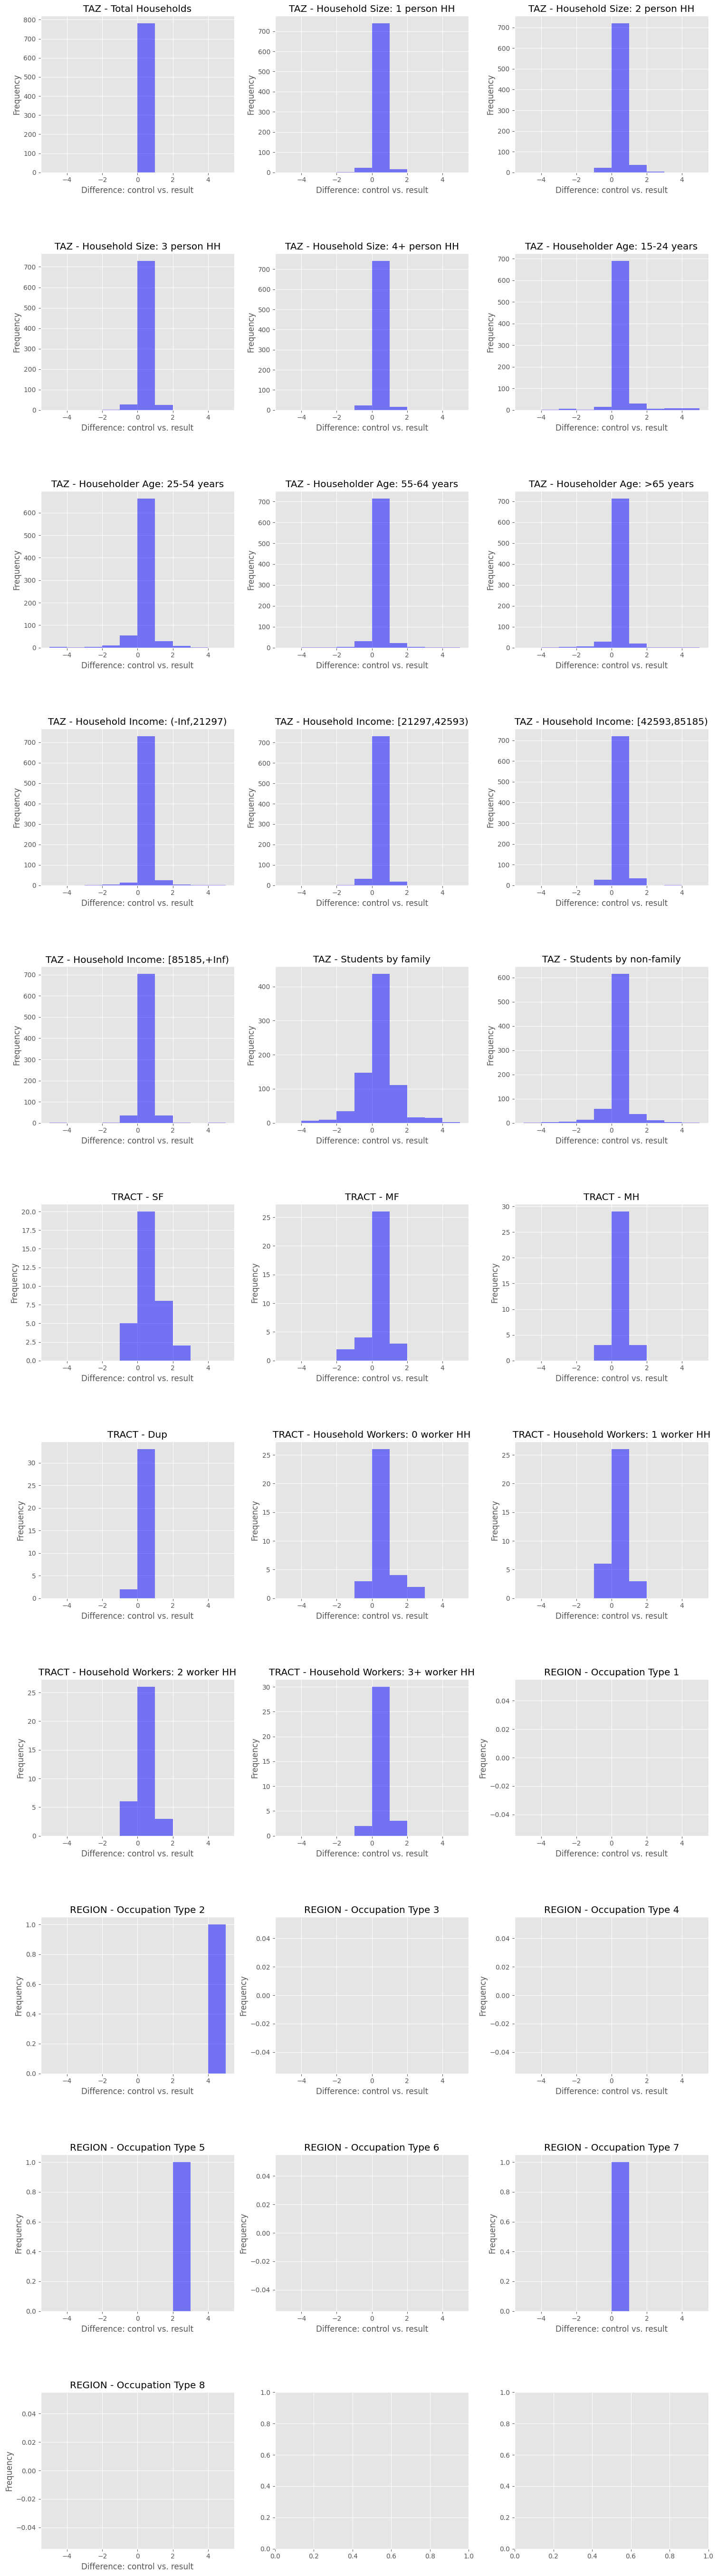

In [23]:
fig_w = 3
fig_l = int(len(aggregate_list) / fig_w) + 1

summary_fig, axes = plt.subplots(fig_l, fig_w, figsize=(fig_w * 5,fig_l*5))

stats = []
for params, ax in zip(aggregate_list, axes.ravel()):
    s, f, diff = process_control(summary_df, **params)
    stats.append(s)
    
    ax.set_title(f"{params['geography']} - {params['name']}")
    ax.set_ylabel('Frequency'); ax.set_xlabel('Difference: control vs. result')
    ax.hist(diff, bins=10, range=(-5,5), alpha=0.5)

summary_fig.savefig(os.path.join(validation_dir, 'frequencies.pdf'))
stats_df = pd.DataFrame(stats)
stats_df.to_csv(os.path.join(validation_dir, f'{scenario}_{region}_popsim_stats.csv'), index=False)

### Calculate the standard deviation for each comparison

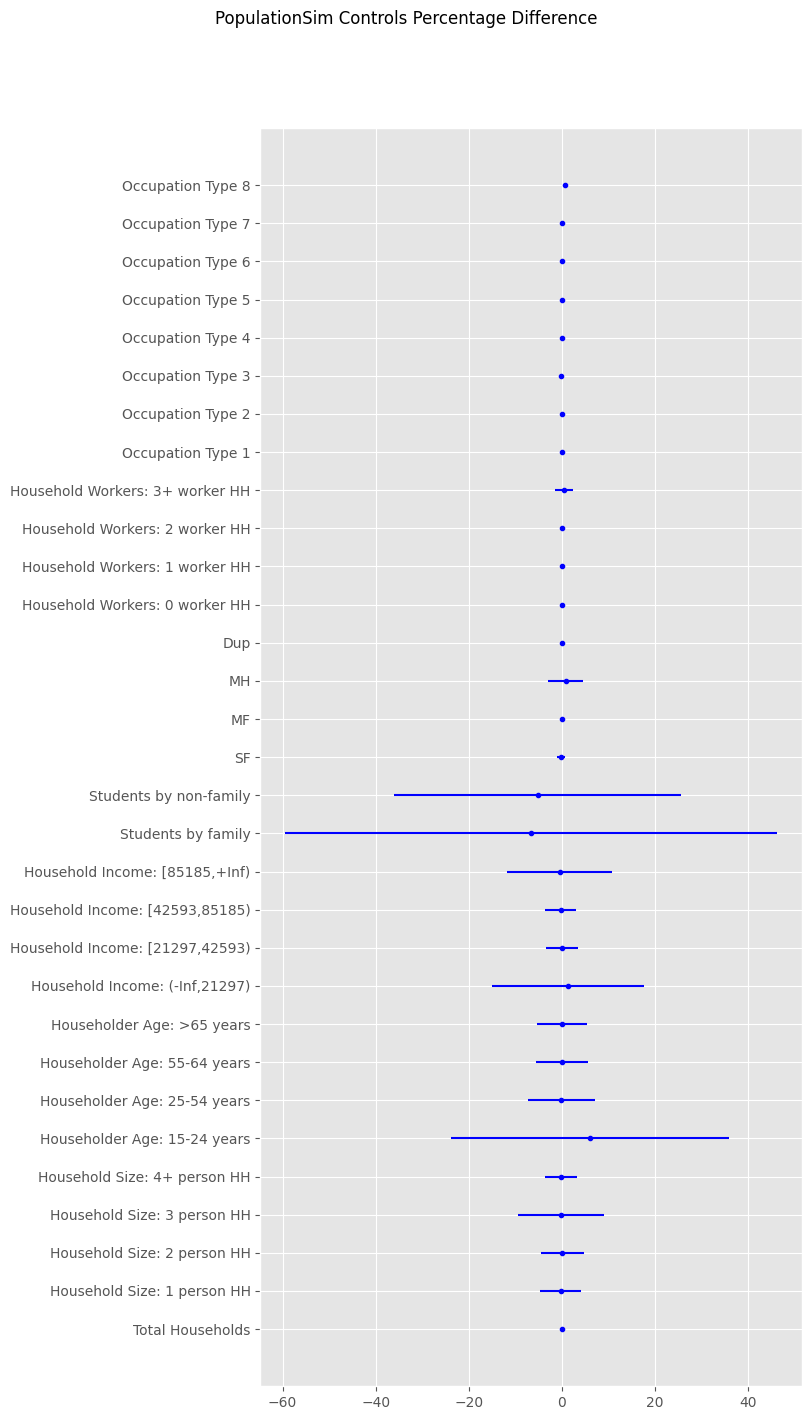

In [24]:
std_fig = plt.figure()
std_fig.suptitle('PopulationSim Controls Percentage Difference')
plt.errorbar(stats_df['mean_pc_difference'],
             stats_df['name'],
             xerr=stats_df['std'],
             linestyle='None',
             marker='.')

std_fig.savefig(os.path.join(validation_dir, f'{scenario}_{region}_popsim_convergence_stdev.pdf'))

## Uniformity

Examine the household weight distribution by geography using `expanded_hhid` and `seed_households`
```yaml
seed_cols:
    geog: PUMA
    geog_weight: WGTP
    hh_id: hh_id
```

In [28]:
seed_cols = (seed_hh_cols.values())
geog = seed_hh_cols.get('geog')
geog_weight = seed_hh_cols.get('geog_weight')
hh_id = seed_hh_cols.get('hh_id')

expanded_hhids = pd.read_csv(os.path.join(popsim_dir, exp_hh_file), usecols=[exp_hh_id_col])
seed_hh_df = pd.read_csv(os.path.join(popsim_dir, seed_hh_file), usecols=seed_cols, index_col=hh_id)

Weight each household by its frequency in the household file, and by the given weight column. Group by geography and summarize.

In [29]:
weight_mask = seed_hh_df[geog_weight] > 0
weight = expanded_hhids[exp_hh_id_col].value_counts()[weight_mask]
expansion_factor = (weight/seed_hh_df[geog_weight]).fillna(0)

df = pd.DataFrame({
    geog: seed_hh_df[geog],
    geog_weight: seed_hh_df[geog_weight],
    'weight': weight,
    'ef': expansion_factor,
})

geog_group = df.groupby(geog)
geog_final_weight = geog_group.sum()['weight']
expansion = geog_final_weight/geog_group.sum()[geog_weight]

expansion.name = 'avg_expansion'
df = df.join(expansion, on=geog)
df['diff_sq'] = (df['avg_expansion'] - df['ef']) ** 2
rmse = df.groupby(geog).mean()['diff_sq'] ** 0.5

uniformity_df = pd.DataFrame({
    'W': geog_group.sum()[geog_weight],
    'Z': geog_group.sum()['weight'],
    'N': geog_group.count()[geog_weight],
    'EXP': expansion,
    'EXP_MIN': geog_group.min()['ef'],
    'EXP_MAX': geog_group.max()['ef'],
    'RMSE': rmse, 
})

uniformity_df.to_csv(os.path.join(validation_dir, 'uniformity.csv'))
uniformity_df

,W,Z,N,EXP,EXP_MIN,EXP_MAX,RMSE
PUMA,,,,,,,
600,77536,62041.0,4841,0.800157,0.0,17.0,0.947148


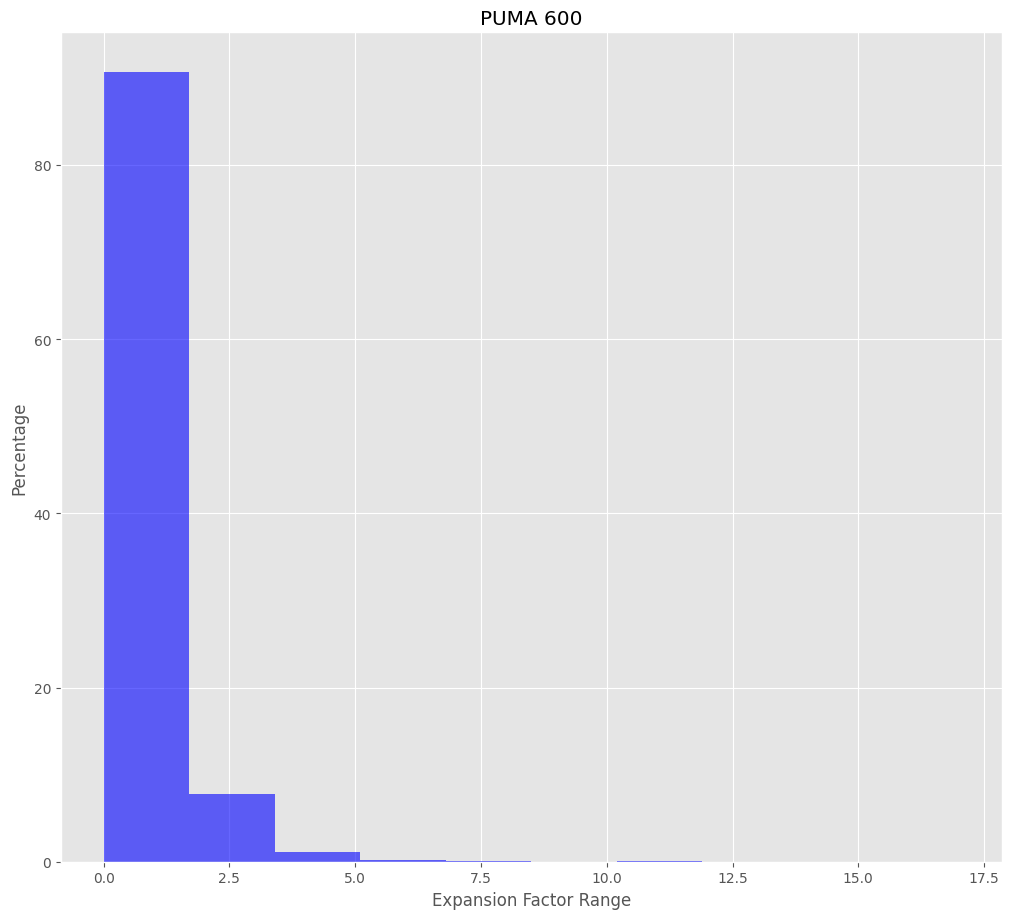

In [30]:
geogs = df[geog].unique()
geog_fig = plt.figure(figsize=(10*len(geogs), 10))

for i, g in enumerate(geogs):
    geog_df = df[df[geog] == g]
    counts, bins = np.histogram(geog_df['ef'])
    ax = geog_fig.add_subplot(1, len(geogs), i+1)
    ax.set_title(f'{geog} {g}')
    ax.set_ylabel('Percentage'); ax.set_xlabel('Expansion Factor Range')
    ax.hist(bins[:-1], bins, weights=counts*100/len(geog_df), alpha=0.6)